# 프로젝트: 인물 모드 문제점 찾기
---
#### 주요 라이브러리

In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

import os
from pixellib.semantic import semantic_segmentation
# semantic segmentation 모델 loading
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 


4.5.3
0.7.1


## Step 1. 인물모드 만들기
- semantic_segmentation 로 이미지로 부터 label 추출 및 확인하는 함수 구현
- 이미지의 label에 blurring 처리를 하는 함수 구현
- 이미지의 label에 마스킹 이미지를 합성하는 함수 구현
---
### 이미지의 segvalues 라벨 확인 함수 구현

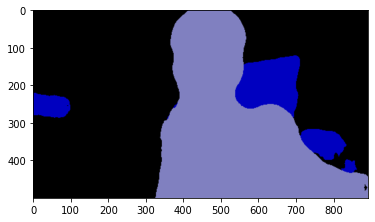

background: RGB(0, 0, 0)
chair: RGB(0, 0, 192)
person: RGB(128, 128, 192)


In [2]:
from matplotlib import pyplot as plt
import numpy as np

# pascalvoc 라벨명 리스트
def get_pascalvoc_labels():
    return [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]

# pascalvoc 라벨 컬러맵
def get_colormap():
    if not 'colormap_' in globals():
        global colormap_
        colormap_ = np.zeros((256, 3), dtype = int)
        ind = np.arange(256, dtype=int)
        for shift in reversed(range(8)):
            for channel in range(3):
                colormap_[:, channel] |= ((ind >> channel) & 1) << shift
            ind >>= 3
        colormap_[:20] #생성한 20개의 컬러맵 출력
    return colormap_

# pascalvoc 라벨 RGB 컬러
def get_rgb_of_label(label):
    colormap = get_colormap()
    labels = get_pascalvoc_labels()
    seg_color = colormap[labels.index(label)]
    b = seg_color[0]
    g = seg_color[1]
    r = seg_color[2]
    return (r, g, b)

# segment 정보 확인
'''
Parameter
- img_path : 이미지 경로
- show : segment 정보 출력 여부

Return
- img_orig : 원본 cv2 이미지 객체, 
- output : Pascalvoc 시그먼트 분할 output
'''
def get_segment_info(img_path, show = False):
    labels = get_pascalvoc_labels()
    # 입력된 이미지를 분할한다.
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    if show == True:
        plt.imshow(output)
        plt.show()
        for class_id in segvalues['class_ids']:
            label = labels[class_id]
            r, g, b = get_rgb_of_label(label)
            print('{}: RGB({}, {}, {})'.format(label, r, g, b))
    
    img_orig = cv2.imread(img_path)
    return img_orig, output

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'
(img_orig, output) = get_segment_info(img_path, True)

### 이미지의 label을 blurring 처리를 하는 함수

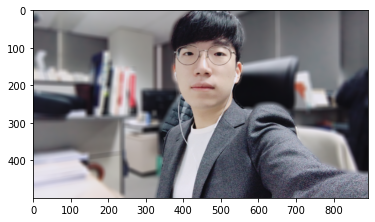

In [3]:
'''
Parameter
- img_orig : cv2 이미지 객체
- output : 이미지 분할 output
- label: 마스킹 label명
- is_label_blurring : label 블러 여부(default: False)
    False - label 블러 제외, True - label 블러 처리
- ksize: 블러링 커널 사이즈

Return
- 블러 처리 적용 cv2 이미지 객체
'''    
def get_blurring_img(img_orig, output, label, is_label_blurring=False, ksize = (13, 13)):
    
    img_orig_blur = cv2.blur(img_orig, ksize)
    
    # label segment
    seg_color = get_rgb_of_label(label)
    seg_map = np.all(output == seg_color, axis=-1)    
    
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255
    
    # mask 이미지를 BGR 채널로 변경
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    a, b  = img_orig, img_orig_blur
    if is_label_blurring:
        a, b  = img_orig_blur, img_orig
        
        
    img_concat = np.where(img_mask_color==255, a, b)
    return cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)

plt.imshow(get_blurring_img(img_orig, output, 'person'))
plt.show()
    

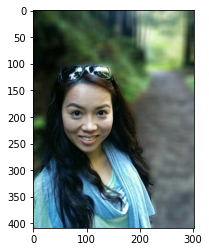

In [6]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sample1.jpg'
(img_orig, output) = get_segment_info(img_path)
plt.imshow(get_blurring_img(img_orig, output, 'person'))
plt.show()

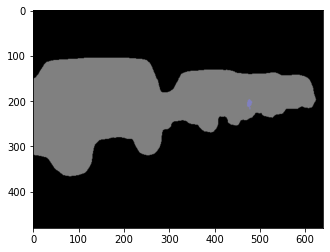

background: RGB(0, 0, 0)
car: RGB(128, 128, 128)
person: RGB(128, 128, 192)


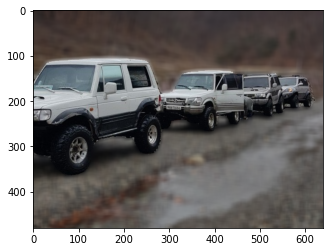

In [8]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sample2.jpg'
(img_orig, output) = get_segment_info(img_path, True)
plt.imshow(get_blurring_img(img_orig, output, 'car'))
plt.show()

## Step2 사진에서 문제점 찾기
---
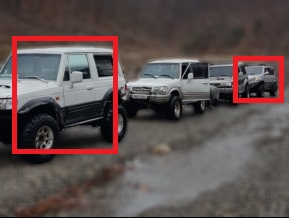
같은 label의 피사체가 동일한 처리가 되어 실제 피사체의 거리와 관련 없는 아웃포커싱 처리가 된다.

## Step3 해결방법 제안
---
1. 인스턴스 세그멘테이션(Instance Segmentation)으로 같은 label의 피사체를 인스턴스 별로 분리한다.
2. 인스턴스 별로 피사체의 거리를 예측한다.
3. 인스턴스 거리 별로 blur 적용 여부 또는 blurring kernel size값을 다르게 적용한다.
